# 1-month_Prediction_Alkalis

## TO-DOs
```
## Python 3.8
[v] Import monthly electrcity data
[v] Import monthly TTF_GAS data
[v] Import price evaluatioin data
[v] Create rows and encoding Alkalis_RM02_0001, Alkalis_RM02_0002
[v] To calculate the monthly average prices of Alkalis
[v] Create 12*N features, external factor prices from one-month before to 12-month before
[v] Combine features with target variables
[v] train_test_split() - do calculation and scaling only based on train data set to prevent data leakage
[x] Detect outliers - skip
[v] Check data distribution
[v] Data scaling - log transformation and standardlisation
[x] check multicollinearity(to run one regression using each features, and find corr of all feature, filtering those with higher performance and least corr for our last model) - skip
[v] Lasso regression - fit and transform train data set
[v] Cross validation and Hyperparameter tuning using RandomizedSearchCV
[v] Lasso regression - transform test data set
[v] Lasso regression - transform new data and match the predicted values with real values
[v] Visualisation - all Key RM codes
[v] Visualisation - individual Key RM codes
[] Compare Lasso with Naive forecast
```

In [1]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import preprocessor as pre
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## Import monthly electrcity data
## Import monthly TTF_GAS data
## Import price evaluatioin data
## Create rows and encoding Alkalis_RM02_0001, Alkalis_RM02_0002
## To calculate the monthly average prices of Alkalis
## Create 12*N features, external factor prices from one-month before to 12-month before
## Combine features with target variables

gas_df = pre.get_Fred_data('PNGASEUUSDM',2011,2023)
elec_df = pre.clean_elec_csv('Data_flat_files/ELECTRICITY_02_2024.csv',2011,2023)
price_evo_df = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Predicting_Price_Evolutions_202310.csv',2012,2023)

dummy_df = pre.get_dummies_and_average_price(price_evo_df,'Alkalis',\
                                         'RM02/0001','RM02/0002')

Alkalis_df = pre.generate_features(1,12,dummy_df,Electricity=elec_df,PNGASEUUSDM=gas_df)
# print(Alkalis_df.info())

In [4]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Create X, y
feature_list = Alkalis_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = Alkalis_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [8]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)

# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")

Best alpha parameter: 0.01700576685561854
Best R-squared score: 0.881
Coefficients of the selected features in the best Lasso model:
RM02/0002: 0.689
Electricity_1: 0.28
PNGASEUUSDM_1: 0.109
Electricity_2: 0.08
PNGASEUUSDM_2: 0.0
Electricity_3: 0.099
PNGASEUUSDM_3: 0.0
Electricity_4: 0.0
PNGASEUUSDM_4: 0.0
Electricity_5: 0.0
PNGASEUUSDM_5: 0.0
Electricity_6: 0.076
PNGASEUUSDM_6: 0.0
Electricity_7: 0.0
PNGASEUUSDM_7: 0.0
Electricity_8: 0.083
PNGASEUUSDM_8: -0.0
Electricity_9: 0.0
PNGASEUUSDM_9: -0.0
Electricity_10: 0.0
PNGASEUUSDM_10: 0.0
Electricity_11: 0.0
PNGASEUUSDM_11: -0.0
Electricity_12: 0.0
PNGASEUUSDM_12: -0.0


In [9]:
## Lasso regression - transform test data set

# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_

# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

Best Model: Lasso(alpha=0.01700576685561854)
Test Set R-squared score: 0.871


In [11]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data
gas_df = pre.get_Fred_data('PNGASEUUSDM',2011,2024)
elec_df = pre.clean_elec_csv('Data_flat_files/ELECTRICITY_02_2024.csv',2011,2024)

price_evo_df = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2012,2024)

dummy_df = pre.get_dummies_and_average_price(price_evo_df,'Alkalis',\
                                         'RM02/0001','RM02/0002')
Alkalis_df_24 = pre.generate_features(1,12,dummy_df,Electricity=elec_df,PNGASEUUSDM=gas_df)

# Create X, y
feature_list = Alkalis_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list.values
y_24 = Alkalis_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f'MAPE: {mape_24:.3f}')

# To match the predicted values with original df
Alkalis_df_24['Prediction_1_Month'] = y_pred_24_inverse
print(Alkalis_df_24[['Time','RM02/0002','Average_price','Prediction_1_Month']]
      .loc[(Alkalis_df_24['Time'] > '2023-12-31') & (Alkalis_df_24['Prediction_1_Month'].notnull())])


MAPE: 0.145
          Time  RM02/0002  Average_price  Prediction_1_Month
144 2024-01-31          0       0.342479            0.264447
145 2024-02-29          0       0.275000            0.259515
146 2024-03-20          0       0.275000            0.247736
289 2024-01-30          1       0.568454            0.572312
290 2024-02-29          1       0.640000            0.561639
291 2024-03-15          1       0.542000            0.536145


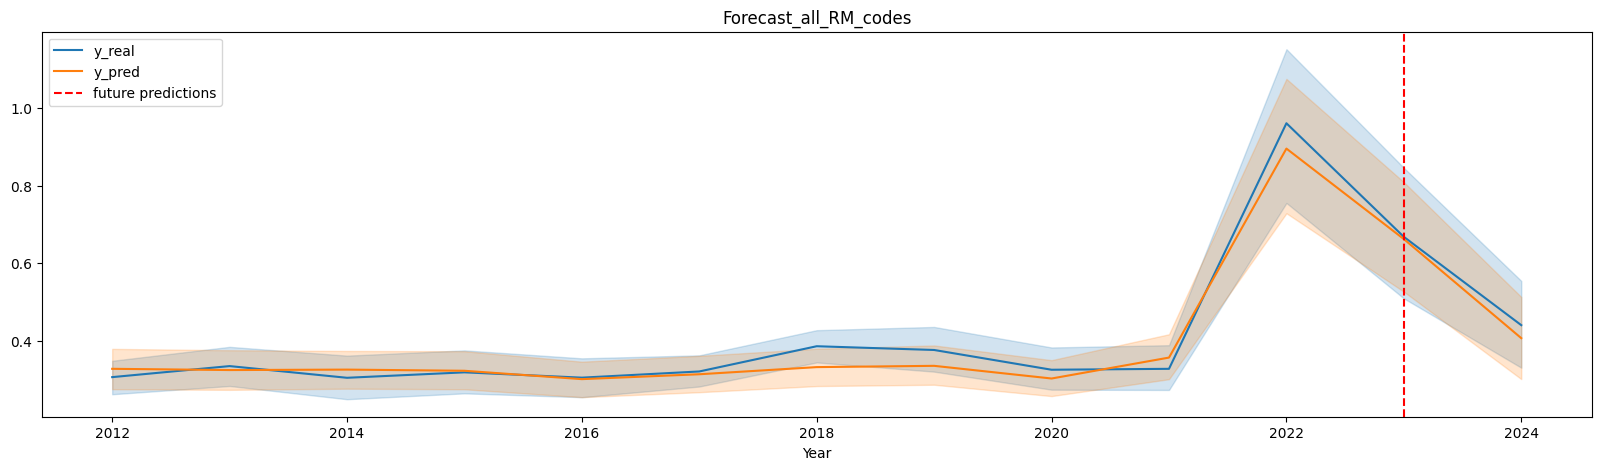

In [12]:
## Visualisation - all Key RM codes
fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=Alkalis_df_24, x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=Alkalis_df_24, x='Year', y=y_pred_24_inverse, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast_all_RM_codes', ylabel='');

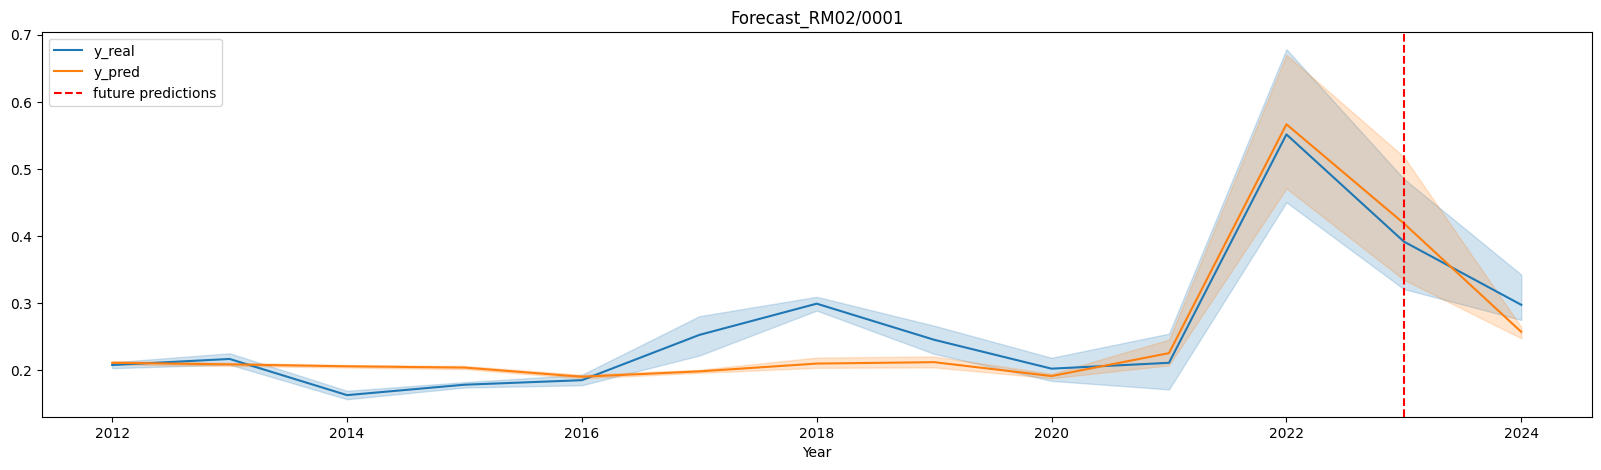

In [13]:
## Visualisation - individual Key RM codes
# Visualisation for RM02/0001
filter = (Alkalis_df_24['RM02/0002'] == 0)
X_24_01 = feature_list[filter].values
y_24_01 = Alkalis_df_24[filter]['Average_price'].values

X_scaled_24_01 = scaler_x.transform(X_24_01)

y_pred_24_01 = best_lasso_model.predict(X_scaled_24_01)
y_pred_24_inverse_01 = np.exp(scaler_y.inverse_transform(y_pred_24_01.reshape(-1,1))).reshape(-1)


fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=Alkalis_df_24[filter], x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=Alkalis_df_24[filter], x='Year', y=y_pred_24_inverse_01, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast_RM02/0001', ylabel='');

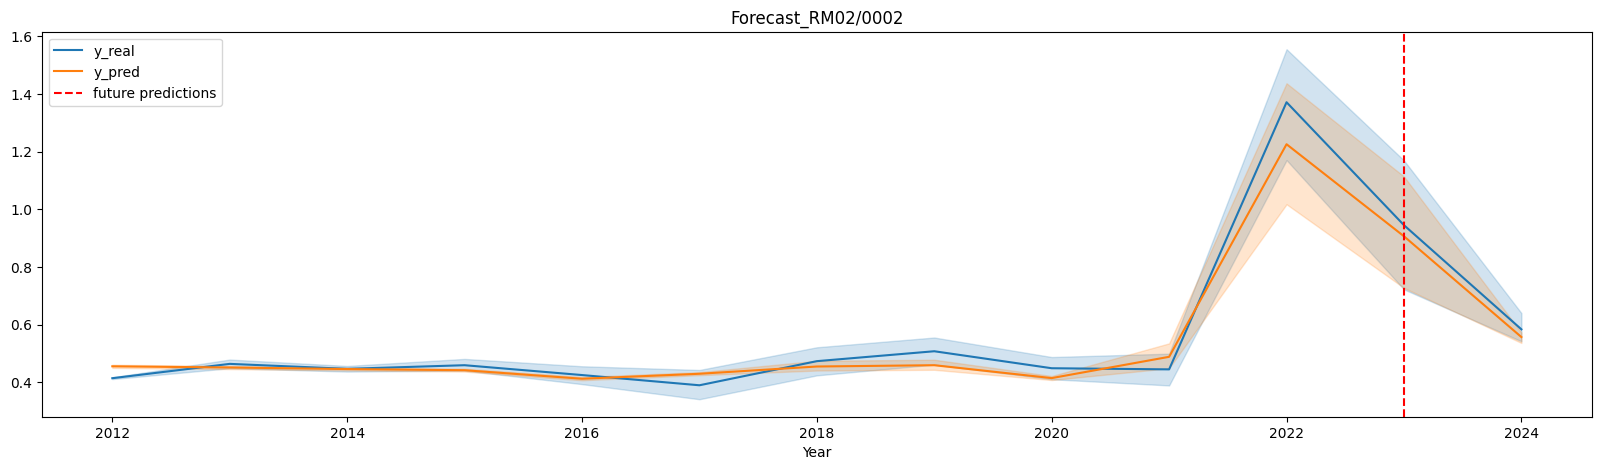

In [14]:
## Visualisation - individual Key RM codes
# Visualisation for RM02/0002
filter = (Alkalis_df_24['RM02/0002'] == 1)
X_24_02 = feature_list[filter].values
y_24_02 = Alkalis_df_24[filter]['Average_price'].values

X_scaled_24_02 = scaler_x.transform(X_24_02)

y_pred_24_02 = best_lasso_model.predict(X_scaled_24_02)
y_pred_24_inverse_02 = np.exp(scaler_y.inverse_transform(y_pred_24_02.reshape(-1,1))).reshape(-1)


fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=Alkalis_df_24[filter], x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=Alkalis_df_24[filter], x='Year', y=y_pred_24_inverse_02, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast_RM02/0002', ylabel='');